Creating x86_64 directory for .o files.

/home/main/notebooks
hh_pump.mod hhrx.mod
hh_pump.mod hhrx.mod
"/home/main/neuron/nrn-7.4/x86_64/bin/nocmodl" hh_pump
Translating hh_pump.mod into hh_pump.c
Thread Safe
"/home/main/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/main/neuron/nrn-7.4/include/nrn" -I"/home/main/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o hh_pump.lo hh_pump.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/main/neuron/nrn-7.4/include/nrn -I/home/main/neuron/nrn-7.4/x86_64/lib -g -O2 -c hh_pump.c  -fPIC -DPIC -o .libs/hh_pump.o
"/home/main/neuron/nrn-7.4/x86_64/bin/nocmodl" hhrx
Translating hhrx.mod into hhrx.c
Thread Safe
"/home/main/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/main/neuron/nrn-7.4/include/nrn" -I"/home/main/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o hhrx.lo hhrx.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/main/neuron/nrn-7.4/include/nrn -I/h

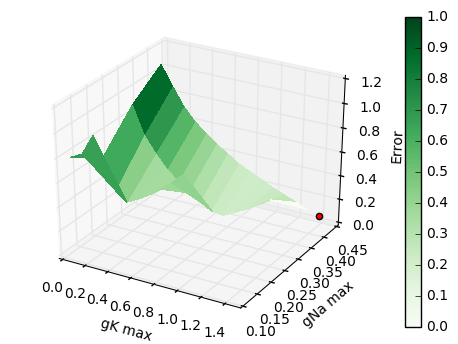

In [12]:
!rm -r x86_64
!nrnivmodl
from __future__ import division
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#from peakutils.peak import indexes
import math
%matplotlib inline

def deriv(a,b):
	der=[]
	if len(a)!=len(b):
		print ('cant calculate derivative')
	else:
		for i in range(len(a)-1):
			der.append((a[i+1]-a[i])/(b[i+1]-b[i]))
		return der
		
def initialize():
	h.finitialize()
	h.fcurrent()
def integrate():
	#g.begin()
	h.finitialize()
	while h.t<tstop:
		h.fadvance()
		
		
#def number_peaks(a):
	#number_of_peaks = 0
#	index = indexes(np.array(a))
#	return len(index)
	
cell=h.Section()
cell.nseg=99
cell.insert('hh_pump')



cell.L=40*1000  #um
cell.diam=506  #um

#cell.ek = -73
#cell.ena = 53

print cell.ena, cell.ek

#stimualtion parameters
stim1=h.IClamp(0,sec=cell)
stim1.delay=50 #ms
stim1.dur=1 #ms
stim1.amp=5000 #nA

cell.cm = 1

tstop=100
h.dt=0.01
vec = {}

max_iterations = 500
gk_bar = np.arange(0.036, 1.50, 0.1)

gna_bar = np.arange(0.12, 0.46, 0.1)
print len(gna_bar), len(gk_bar)

temperature = 25
rof_expt = 521
ror_expt = 757
tol = 0.01
i = 0
j = 0

error_gk = np.zeros((len(gna_bar), len(gk_bar)))
error_gna = np.zeros((len(gna_bar), len(gk_bar)))
for new_gna_bar in gna_bar:
	j = 0
	for new_gk_bar in gk_bar:
		
		cell.gkbar_hh_pump = new_gk_bar
		cell.gnabar_hh_pump = new_gna_bar
	
		cell.localtemp_hh_pump = temperature
	
	
		for var in 't','v_0.5':
				vec[var]=h.Vector()
	
		vec['t'].record(h._ref_t)
		vec['v_0.5'].record(cell(0.5)._ref_v)
	
	
		initialize()
		integrate()
	
	#	plt.plot(vec['v_0.5'])
	#	plt.show()
	
		ror_model = max(deriv(vec['v_0.5'],vec['t']))
		rof_model = min(deriv(vec['v_0.5'],vec['t']))
	
		
		
		if max(vec['v_0.5']) < -30:
			print ("AP failed")
			error1 = np.nan
			error2 = np.nan
#		elif number_peaks(vec['v_0.5']) > 1:
#			print ('spontaneous activity observed')
#			error1 = np.nan
#			error2 = np.nan
		elif abs(abs(rof_model) - abs(rof_expt))/rof_expt < tol:
			print ('tolerance level reached')
			#break
		else:
			error1 = abs(abs(rof_model) - abs(rof_expt))/rof_expt 
			error2 = abs(abs(ror_model) - abs(ror_expt))/ror_expt
		print i, j, i*j + j, cell.gkbar_hh_pump, cell.gnabar_hh_pump, error1, error2
	
		
		error_gk[i,j] = error1
		error_gna[i,j] = error2
		
		j = j + 1
	
#		if abs(rof_model) > abs(rof_expt):
#			new_gk_bar = new_gk_bar*0.99
#			new_gna_bar = new_gna_bar*0.99
#		else:
#			new_gk_bar = new_gk_bar*1.05
#			new_gna_bar = new_gna_bar*1.02 #adjust the Na conductance to produce an AP
	
		
	
		#iteration = iteration +1
	i = i+1
    

x = np.arange(0.036, 1.50, 0.1)

y = np.arange(0.12, 0.46, 0.1)





data1 = error_gna
data2 = error_gk

total = data1+data2


#print np.nanmin(total)

a = np.where(total == np.nanmin(total))
print x[a[1][0]], y[a[0][0]]
#print 
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')  
X, Y = np.meshgrid(x,y)

ax.set_xlabel('gK max')
ax.set_ylabel('gNa max')
ax.set_zlabel('Error')
surf1 = ax.plot_surface(X, Y, data1+data2, rstride=1, cstride=1, cmap = cm.Greens, vmin = 0, vmax = 1,linewidth=0, antialiased=False)
ax.scatter(x[a[1][0]], y[a[0][0]], np.nanmin(total), c = 'red', marker = 'o', s = 20)
fig.colorbar(surf1)

plt.xlim(0, 1.50)
plt.show()


In [1]:
!nrnivmodl

/home/main/notebooks
hh_pump.mod hhrx.mod
hh_pump.mod hhrx.mod
"/home/main/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/main/neuron/nrn-7.4/include/nrn" -I"/home/main/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/main/neuron/nrn-7.4/include/nrn -I/home/main/neuron/nrn-7.4/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/home/main/neuron/nrn-7.4/share/nrn/libtool"  --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/home/main/neuron/nrn-7.4/x86_64/lib"  hh_pump.lo hhrx.lo mod_func.lo  -L"/home/main/neuron/nrn-7.4/x86_64/lib" -lnrnoc -loc -lmemacs -lnrnmpi -lscopmath -lsparse13 -lreadline -lncurses -L"/home/main/neuron/nrn-7.4/x86_64/lib" "/home/main/neuron/nrn-7.4/x86_64/lib/libnrniv.la" -livoc -lneuron_gnu -lmeschach -lsundials -livos      -lm -ldl
libtool: link: gcc -shared  -fPIC -DPIC  .libs/hh_pump.o .libs/hhrx.o .libs/mod_func.o   -Wl

In [2]:
!rm -r x86_64

In [3]:
!nrnivmodl

Creating x86_64 directory for .o files.

/home/main/notebooks
hh_pump.mod hhrx.mod
hh_pump.mod hhrx.mod
"/home/main/neuron/nrn-7.4/x86_64/bin/nocmodl" hh_pump
Translating hh_pump.mod into hh_pump.c
Thread Safe
"/home/main/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/main/neuron/nrn-7.4/include/nrn" -I"/home/main/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o hh_pump.lo hh_pump.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/main/neuron/nrn-7.4/include/nrn -I/home/main/neuron/nrn-7.4/x86_64/lib -g -O2 -c hh_pump.c  -fPIC -DPIC -o .libs/hh_pump.o
"/home/main/neuron/nrn-7.4/x86_64/bin/nocmodl" hhrx
Translating hhrx.mod into hhrx.c
Thread Safe
"/home/main/neuron/nrn-7.4/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/main/neuron/nrn-7.4/include/nrn" -I"/home/main/neuron/nrn-7.4/x86_64/lib"      -g -O2 -c -o hhrx.lo hhrx.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/main/neuron/nrn-7.4/include/nrn -I/h